# 训练过程，尝试不同的正则化系数 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from network import Network
from solver import train, test
from plot import plot_loss_and_acc

## 读入MNIST数据集

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def decode_image(image):
    # 归一化处理
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    image = image / 255.0
    image = image - tf.reduce_mean(image)
    return image

def decode_label(label):
    # 将标签变为one-hot编码
    return tf.one_hot(label, depth=10)

In [4]:
# 数据预处理
x_train = tf.data.Dataset.from_tensor_slices(x_train).map(decode_image)
y_train = tf.data.Dataset.from_tensor_slices(y_train).map(decode_label)
data_train = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(x_test).map(decode_image)
y_test = tf.data.Dataset.from_tensor_slices(y_test).map(decode_label)
data_test = tf.data.Dataset.zip((x_test, y_test))

In [5]:
import time
from criterion import EuclideanLossLayer,SoftmaxCrossEntropyLossLayer
from optimizer import SGD
from layers import FCLayer, SigmoidLayer, ReLULayer

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
exec_result = pd.DataFrame(columns=['mode','batch_size','learning_rate_SGD', 'momentum','weight_decay','time','loss_validate','acc_validate'])

max_epoch = 20
disp_freq = 50
init_std = 0.01

In [6]:
learning_rate_SGD = 0.001

for batch_size in [10, 50, 100, 300, 600]:
    #Euclidean+Sigmoid
    momentum = 0.55
    weight_decay= 0.0001
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]   

    #Euclidean+ReLU
    momentum = 0.99
    weight_decay= 0.0001
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    reluMLP = Network()
    # 使用FCLayer和ReLULayer构建多层感知机
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]     

    #CrossEntropy+Sigmoid
    momentum = 0.55
    weight_decay= 0.00001
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]         

    #CrossEntropy+ReLU
    momentum = 0.99
    weight_decay= 0.00001
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    reluMLP = Network()
    t1=time.time()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]      

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Epoch [0][20]	 Batch [0][5500]	 Training Loss 6.6369	 Accuracy 0.0000
Epoch [0][20]	 Batch [50][5500]	 Training Loss 1.4241	 Accuracy 0.0882
Epoch [0][20]	 Batch [100][5500]	 Training Loss 1.0243

In [7]:
exec_result['acc_validate_float'] = exec_result['acc_validate'].map(lambda x: np.average(x))
exec_result

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
0,Euclidean_Sigmoid,10,0.001,0.55,0.00010,202.992379,"[0.23696529033491118, 0.21295889748507354, 0.2...","[0.8358000000000001, 0.8702000000000001, 0.879...",0.893160
1,Euclidean_ReLU,10,0.001,0.99,0.00010,202.865551,"[0.07850324827173032, 0.06918276771896614, 0.0...","[0.9466, 0.9546, 0.9596000000000001, 0.9642000...",0.967250
2,CrossEntropy_Sigmoid,10,0.001,0.55,0.00001,220.172044,"[0.8776581632144806, 0.5738326347256689, 0.457...","[0.8642000000000002, 0.8942, 0.905, 0.9134, 0....",0.922080
3,CrossEntropy_ReLU,10,0.001,0.99,0.00001,213.903324,"[0.12273972706776996, 0.09220356944746999, 0.0...","[0.9658000000000001, 0.971, 0.9770000000000001...",0.981260
4,Euclidean_Sigmoid,50,0.001,0.55,0.00010,84.205458,"[0.33334949700556904, 0.28014550534958116, 0.2...","[0.6496, 0.7664, 0.8048000000000001, 0.8263999...",0.844620
5,Euclidean_ReLU,50,0.001,0.99,0.00010,103.404958,"[0.09226160089623736, 0.07735723972868697, 0.0...","[0.9314, 0.9450000000000002, 0.948000000000000...",0.958730
6,CrossEntropy_Sigmoid,50,0.001,0.55,0.00001,106.531004,"[1.832304787036741, 1.461818502020953, 1.20390...","[0.6298, 0.7616000000000003, 0.8164, 0.8456, 0...",0.868030
7,CrossEntropy_ReLU,50,0.001,0.99,0.00001,110.083097,"[0.17114324509297812, 0.12833095406247166, 0.1...","[0.9540000000000001, 0.9658, 0.97, 0.972399999...",0.975220
8,Euclidean_Sigmoid,100,0.001,0.55,0.00010,86.230360,"[0.4049494244660077, 0.3307651218876163, 0.296...","[0.46959999999999996, 0.6522, 0.73, 0.77139999...",0.810190
9,Euclidean_ReLU,100,0.001,0.99,0.00010,86.719688,"[0.1452353369806154, 0.10322973457606605, 0.09...","[0.8859999999999999, 0.9181999999999999, 0.932...",0.942630


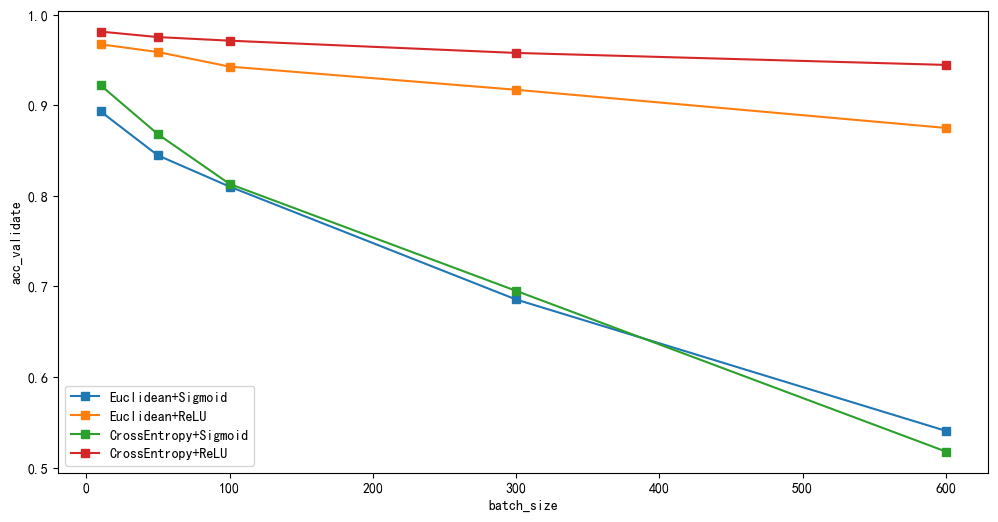

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['batch_size'], exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'], marker='s', label = 'Euclidean+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['batch_size'], exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'], marker='s', label = 'Euclidean+ReLU')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['batch_size'], exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'], marker='s', label = 'CrossEntropy+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['batch_size'], exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'], marker='s', label = 'CrossEntropy+ReLU')
plt.xlabel('batch_size')
plt.ylabel('acc_validate')
plt.legend()

In [9]:
exec_result.to_csv('./result/result_batch_size.csv',index=False)
# # euclidean_sigmoid.learning_rate_SGD, euclidean_relu.learning_rate_SGD, crossEntropy_sigmoid.learning_rate_SGD, crossEntropy_relu.learning_rate_SGD

# exec_result=pd.read_csv('./result_learning_rate_SGD.csv')

In [10]:
best_index = exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'].idxmax()
euclidean_sigmoid= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'].idxmax()
euclidean_relu= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'].idxmax()
crossEntropy_sigmoid= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'].idxmax()
crossEntropy_relu= exec_result.loc[best_index]
euclidean_sigmoid.weight_decay, euclidean_relu.weight_decay, crossEntropy_sigmoid.weight_decay, crossEntropy_relu.weight_decay

(0.0001, 0.0001, 1e-05, 1e-05)

In [11]:
exec_result.query("weight_decay <= 0.00010")

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
0,Euclidean_Sigmoid,10,0.001,0.55,0.00010,202.992379,"[0.23696529033491118, 0.21295889748507354, 0.2...","[0.8358000000000001, 0.8702000000000001, 0.879...",0.893160
1,Euclidean_ReLU,10,0.001,0.99,0.00010,202.865551,"[0.07850324827173032, 0.06918276771896614, 0.0...","[0.9466, 0.9546, 0.9596000000000001, 0.9642000...",0.967250
2,CrossEntropy_Sigmoid,10,0.001,0.55,0.00001,220.172044,"[0.8776581632144806, 0.5738326347256689, 0.457...","[0.8642000000000002, 0.8942, 0.905, 0.9134, 0....",0.922080
3,CrossEntropy_ReLU,10,0.001,0.99,0.00001,213.903324,"[0.12273972706776996, 0.09220356944746999, 0.0...","[0.9658000000000001, 0.971, 0.9770000000000001...",0.981260
4,Euclidean_Sigmoid,50,0.001,0.55,0.00010,84.205458,"[0.33334949700556904, 0.28014550534958116, 0.2...","[0.6496, 0.7664, 0.8048000000000001, 0.8263999...",0.844620
5,Euclidean_ReLU,50,0.001,0.99,0.00010,103.404958,"[0.09226160089623736, 0.07735723972868697, 0.0...","[0.9314, 0.9450000000000002, 0.948000000000000...",0.958730
6,CrossEntropy_Sigmoid,50,0.001,0.55,0.00001,106.531004,"[1.832304787036741, 1.461818502020953, 1.20390...","[0.6298, 0.7616000000000003, 0.8164, 0.8456, 0...",0.868030
7,CrossEntropy_ReLU,50,0.001,0.99,0.00001,110.083097,"[0.17114324509297812, 0.12833095406247166, 0.1...","[0.9540000000000001, 0.9658, 0.97, 0.972399999...",0.975220
8,Euclidean_Sigmoid,100,0.001,0.55,0.00010,86.230360,"[0.4049494244660077, 0.3307651218876163, 0.296...","[0.46959999999999996, 0.6522, 0.73, 0.77139999...",0.810190
9,Euclidean_ReLU,100,0.001,0.99,0.00010,86.719688,"[0.1452353369806154, 0.10322973457606605, 0.09...","[0.8859999999999999, 0.9181999999999999, 0.932...",0.942630
